In [1]:
#
#  tsne.py
#  
# Implementation of t-SNE in Python. The implementation was tested on Python 2.5.1, and it requires a working 
# installation of NumPy. The implementation comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
# The example can be run by executing: ipython tsne.py -pylab
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as Math
import pylab as Plot


def Hbeta(D=Math.array([]), beta=1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

    # Compute P-row and corresponding perplexity
    P = Math.exp(-D.copy() * beta);
    sumP = sum(P);
    H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
    P = P / sumP;
    return H, P;


def x2p(X=Math.array([]), tol=1e-5, perplexity=30.0):
    """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

    # Initialize some variables
    print "Computing pairwise distances..."
    (n, d) = X.shape;
    sum_X = Math.sum(Math.square(X), 1);
    D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
    P = Math.zeros((n, n));
    beta = Math.ones((n, 1));
    logU = Math.log(perplexity);

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print "Computing P-values for point ", i, " of ", n, "..."

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -Math.inf;
        betamax = Math.inf;
        Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i + 1:n]))];
        (H, thisP) = Hbeta(Di, beta[i]);

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU;
        tries = 0;
        while Math.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy();
                if betamax == Math.inf or betamax == -Math.inf:
                    beta[i] = beta[i] * 2;
                else:
                    beta[i] = (beta[i] + betamax) / 2;
            else:
                betamax = beta[i].copy();
                if betamin == Math.inf or betamin == -Math.inf:
                    beta[i] = beta[i] / 2;
                else:
                    beta[i] = (beta[i] + betamin) / 2;

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i]);
            Hdiff = H - logU;
            tries = tries + 1;

        # Set the final row of P
        P[i, Math.concatenate((Math.r_[0:i], Math.r_[i + 1:n]))] = thisP;

        # Return final P-matrix
        print "Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta))
    return P;


def pca(X=Math.array([]), no_dims=50):
    """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

    print "Preprocessing the data using PCA..."
    (n, d) = X.shape;
    X = X - Math.tile(Math.mean(X, 0), (n, 1));
    (l, M) = Math.linalg.eig(Math.dot(X.T, X));
    Y = Math.dot(X, M[:, 0:no_dims]);
    return Y;


def do_tsne(X=Math.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

    # Check inputs
    if X.dtype != "float64":
        print "Error: array X should have type float64.";
        return -1;
    # if no_dims.__class__ != "<type 'int'>":        # doesn't work yet!
    #  print "Error: number of dimensions should be an integer.";
    #  return -1;

    # Initialize variables
    X = pca(X, initial_dims).real;
    (n, d) = X.shape;
    max_iter = 1000;
    initial_momentum = 0.5;
    final_momentum = 0.8;
    eta = 500;
    min_gain = 0.01;
    Y = Math.random.randn(n, no_dims);
    dY = Math.zeros((n, no_dims));
    iY = Math.zeros((n, no_dims));
    gains = Math.ones((n, no_dims));

    # Compute P-values
    P = x2p(X, 1e-5, perplexity);
    P = P + Math.transpose(P);
    P = P / Math.sum(P);
    P = P * 4;  # early exaggeration
    P = Math.maximum(P, 1e-12);
    print "early exageration", P


    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = Math.sum(Math.square(Y), 1);
        num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
        num[range(n), range(n)] = 0;
        Q = num / Math.sum(num);
        Q = Math.maximum(Q, 1e-12);

        # Compute gradient
        PQ = P - Q;
        for i in range(n):
            dY[i, :] = Math.sum(Math.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0);

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
        gains[gains < min_gain] = min_gain;
        iY = momentum * iY - eta * (gains * dY);
        Y = Y + iY;
        Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = Math.sum(P * Math.log(P / Q));
            print "Iteration ", (iter + 1), ": error is ", C

        # Stop lying about P-values
        if iter == 100:
            P = P / 4;

    # Return solution
    return Y;

In [ ]:
print "Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset."
print "Running example on 2,500 MNIST digits..."
X = Math.loadtxt("mnist2500_X.txt");
labels = Math.loadtxt("mnist2500_labels.txt");
Y = do_tsne(X, 2, 50, 20.0);

Populating the interactive namespace from numpy and matplotlib


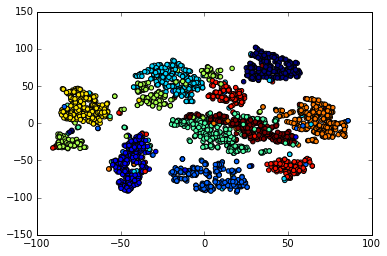

In [4]:
%pylab inline 
Plot.scatter(Y[:,0], Y[:,1], 20, labels);

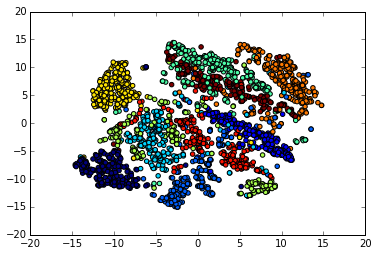

In [5]:
from sklearn.manifold import TSNE

# X = np.loadtxt("mnist2500_X.txt");
# y = np.loadtxt("mnist2500_labels.txt");


# tsne = TSNE(n_components=2, init='pca', random_state=0)
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=4.0, 
            learning_rate=1000.0, n_iter=1000, metric='euclidean', 
            init='pca', verbose=0, random_state=0)

# t# sne.fit(X, y)
y=labels
Y = tsne.fit_transform(X, y)
Plot.scatter(Y[:,0], Y[:,1], 20, labels);
# Plot.scatter(Y[:, 0], Y[:, 1], c=y, cmap=plt.cm.Spectral)

In [7]:
P

NameError: name 'P' is not defined

In [2]:
print "Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset."
print "Running example on 2,500 MNIST digits..."
X = Math.loadtxt("mnist2500_X.txt");
labels = Math.loadtxt("mnist2500_labels.txt");
Y = do_tsne(X, 2, 50, 20.0);

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Mean value of sigma:  1.00060142509
Mean value of sigma:  1.00123214996
Mean value of sigma:  1.00173573458
Mean value of sigma:  1.00195248176
Mean value of sigma:  1.00237106314
Mean value of sigma:  1.0029505695
Mean value of sigma:  1.00332702368
Mean value of sigma:  1.00391003851
Mean value of sigma:  1.00415235099
Mean value of sigma:  1.00469435105
Mean value of sigma:  1.0050858963
Mean value of sigma:  1.00571904465
Mean value of sigma:  1.00645182509
Mean value of sigma:  1.00688856632
Mean value of sigma:  1.00714679125
Mean value of sigma:  1.00754649844
Mean value of sigma:  1.00819174847
Mean value of sigma:  1.00874183569
Mean value of sigma:  1.00929521918
Mean value of sigma:  1.00984669216
Mean value of sigma:  1.0106645968
Mean value of si